In [1]:
import os, sys
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt


In [2]:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES = 256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 100

### Data Preprocessing
Neural machine translation models are often based on seq2seq architecture. The seq2seq architecture is an encoder-decoder architecture which consists of two LSTM. encoder LSTM and decoder LSTM. The input to the encoder LSTM is the sentence in the original language; the input to the decoder LSTM is the sentence in the translated laguage with a start-of-sentence token. Output is the actual targe sentence with an end-of-sentence token.

* eos = end of sentence
* sos = start of sentence

In [5]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open('datasets/france.txt', encoding='utf-8'):
    count += 1

    if count > NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    a = line.rstrip().split('\t')
    input_sentence, output = a[0], a[1]

    output_sentence = output + ' <eos>'
    output_sentences_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentences_input)

print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))


num samples input: 2732
num samples output: 2732
num samples output input: 2732


In [6]:
print(input_sentences[172])
print(output_sentences[172])
print(output_sentences_inputs[172])

Beat it.
Pars ! <eos>
<sos> Pars !


### Tokenization and Padding




In [7]:
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Total unique words in the input: 698
Length of longest sentence in input: 4


In [8]:
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the output: 1942
Length of longest sentence in the output: 11


In [9]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[172]:", encoder_input_sequences[172])

encoder_input_sequences.shape: (2732, 4)
encoder_input_sequences[172]: [ 0  0 61  2]


Since there are 20,000 sentences in input and each input sentence is of length 5, the shape of input is now (20000,5). Here the integer sequence for the sentence at index 172 of input sentence, you can see that there are 3 zeros followed by values 304 and 4. Sentence at index 172 is `Beat it`. The tokenizer divided the sentence into two words `beat` and `it`, converted them into integers, and then applied pre-padding by adding three zeros at the start of the corresponding integer sequence for the sentence at index 172 of input list


To verify that integer for `beat` and `it` are 304 and 4


In [10]:
print(word2idx_inputs["beat"])
print(word2idx_inputs["it"])


61
2


In [11]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[172]:", decoder_input_sequences[172])

decoder_input_sequences.shape: (2732, 11)
decoder_input_sequences[172]: [  2 103   3   0   0   0   0   0   0   0   0]


In the case of decoder, the post-padding is applied, which means that zeros are appended at the end of the sentence. In encoder, zeros were padded at the beginning. The reason behind this approach is that encoder output is based on the words occurring at the end of the sentence, therefore the original words were kept at the end of the sentence and zeros were padded at the beginning. On the other hand, in the case of decoder, the processing starts from beginning of sentence, and therefore post padding is performed on decoder inputs and outputs.


### Word embedding



In [12]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open(r'datasets/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()


Create a matrix where the row number will represent the integer value for the word and the columns will correspond to the dimensions of the word. This matrix will contain the word embeddings for the words in our input sentences.



In [40]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs)+1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [41]:
print(embeddings_dictionary['run'])

KeyError: ignored

In [39]:
print(embedding_matrix[5])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [18]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

### Creating Model
First we define out outputs, as we know that output will be sequence of words. Total number of unique words in output are 9500. Therefore, each word in the output can be any of 9500 words. The length of output sentence is 12. And for each input sentence, we need a corresponding output sentence. Therefore, the final shape of output will be:
`(number of inputs, length of output sentence, number of words in output)`

In [19]:
# create empty output array
decoder_targets_one_hot = np.zeros((len(input_sentences), max_out_len, num_words_output), dtype='float32')

In [20]:
decoder_targets_one_hot.shape


(2732, 11, 1943)

To make predictions, the final layer of the model will be dense layer, therefore we need the outputs in the form of one-hot encoded vectors, since we will be using softmax activation function at the dense layer. To create such one-hot encoded output, the next step is to assign 1 to the column number that corresponds to the integer representation of the word.




In [21]:
for i ,d in enumerate(decoder_input_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i,t,word] = 1

The input to the encoder will be the sentence in English and output will be the hidden state and cell state of the LSTM

In [22]:
encoder_inputs_placeholdre = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholdre)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h,c = encoder(x)
encoder_states = [h,c]

The decoder will have two inputs: hidden state and cell state from the encoder and the input sentence, which actually will be the output sentence with an `<sos>` token appended at beginning

In [23]:
decoder_inputs_placeholder = Input(shape=(max_out_len,))
decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _,_ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

Finally, the output from the decoder LSTM is passed through a dense layer to predict decoder outputs



In [24]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [25]:
model = Model([encoder_inputs_placeholdre, decoder_inputs_placeholder], decoder_outputs)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

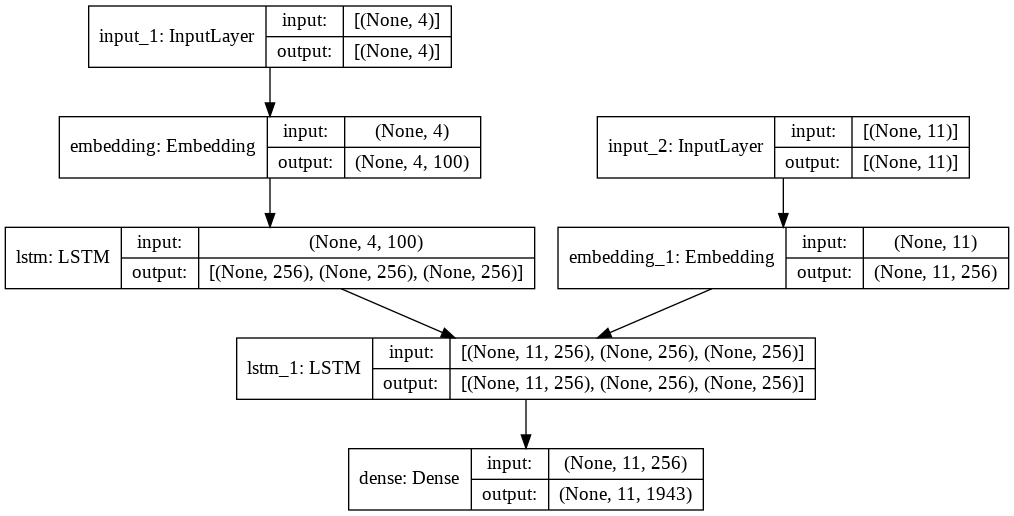

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

Here we have two types of input. `input_1` is the input placeholder for the encoder, which is embedded and passed through `lstm_1` layer, which basically is the encoder LSTM. There are three outputs from `lstm1` layer:
* the output layer
* the hidden layer
* the cell state
However, only the cell state and hidden state are passed to the decoder.

Here `lstm2` layer is decoder LSTM. the `input2` contains the output sentences with `<sos>` token appended at the start. `input2` is also passed through an embedding layer and is used as input to the decoder LSTM, `lstm2`. Finally, the output from decoder LSTM is passed through the dense layer to make predictions.



In [27]:
r = model.fit([encoder_input_sequences, decoder_input_sequences],
              decoder_targets_one_hot,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_split=0.1)

Epoch 1/20
39/39 [==============================] - 12s 201ms/step - loss: 2.5864 - accuracy: 0.7042 - val_loss: 2.0509 - val_accuracy: 0.7087
Epoch 2/20
39/39 [==============================] - 7s 175ms/step - loss: 1.5354 - accuracy: 0.7652 - val_loss: 1.9064 - val_accuracy: 0.7087
Epoch 3/20
39/39 [==============================] - 7s 177ms/step - loss: 1.3346 - accuracy: 0.7943 - val_loss: 1.8126 - val_accuracy: 0.7366
Epoch 4/20
39/39 [==============================] - 7s 175ms/step - loss: 1.1812 - accuracy: 0.8085 - val_loss: 1.6970 - val_accuracy: 0.7432
Epoch 5/20
39/39 [==============================] - 7s 175ms/step - loss: 1.0638 - accuracy: 0.8290 - val_loss: 1.6162 - val_accuracy: 0.7767
Epoch 6/20
39/39 [==============================] - 7s 175ms/step - loss: 0.9632 - accuracy: 0.8428 - val_loss: 1.5243 - val_accuracy: 0.8102
Epoch 7/20
39/39 [==============================] - 7s 175ms/step - loss: 0.8736 - accuracy: 0.8559 - val_loss: 1.4767 - val_accuracy: 0.8258
Epoch

Inputs on the left of Encoder/Decoder, outputs on the right.

step 1:

`I'm ill -> Encoder -> enc(h1,c1)`

`enc(h1,c1) + <sos> -> Decoder -> je + dec(h1,c1)`

step 2:

`enc(h1,c1) + je -> Decoder -> suis + dec(h2,c2)`

step 3:

`enc(h2,c2) + suis -> Decoder -> malade. + dec(h3,c3)`

step 4:

`enc(h3,c3) + malade. -> Decoder -> <eos> + dec(h4,c4)`

However, during predictions the next word will be predicted on the basis of the previous word, which in turn is also predicted in the previous time-step. Now you will understand the purpose of `<sos>` and `<eos>` tokens. While making actual predictions, the full output sequences is not available, in fact that is what we have to predict. During prediction the only word available to us is `<sos>` since all output sentences start with `<sos>`.


// Inputs on the left of Encoder/Decoder, outputs on the right.

Step 1:
`I'm ill -> Encoder -> enc(h1,c1)`

`enc(h1,c1) + <sos> -> Decoder -> je + dec(h1,c1)`

step 2:

`enc(h1,c1) + je -> Decoder -> suis + dec(h2,c2)`

step 3:

`enc(h2,c2) + suis -> Decoder -> malade. + dec(h3,c3)`

step 4:

`enc(h3,c3) + malade. -> Decoder -> <eos> + dec(h4,c4)`

In step1, the hiddne state and cell state of encoder, and the `<sos>` is used as input to the decoder. The decoder predicts a word `y1` which may or may not be true. However, as per our model, the probability of correct prediction is `0.7911`. At step2, the decoder hidden state and cell state from step1, along with `y1`, is used as input to the decoder, which predicts `y2`. The process continues until the `<eos>` token is encountered. All the predicted outputs from decoder are then concatenated to form the final output sentence.

In [28]:
encoder_model = Model(encoder_inputs_placeholdre, encoder_states)

Since now at each step, we need the decoder hidden and cell states, we will modify our model to accept the hidden and cell state as:

In [29]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

Now at each time step, there will be only single word in the decoder input, we need to modify the decoder embedding layer

In [30]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

Next, we need to create the placeholder for decoder outputs

In [31]:
decoder_outputs, h,c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

To make predictions, the decoder output is passed through the dense layer

In [32]:
decoder_States = [h,c]
decoder_outputs = decoder_dense(decoder_outputs)

Final step is to define the update decoder model

In [33]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_States
)

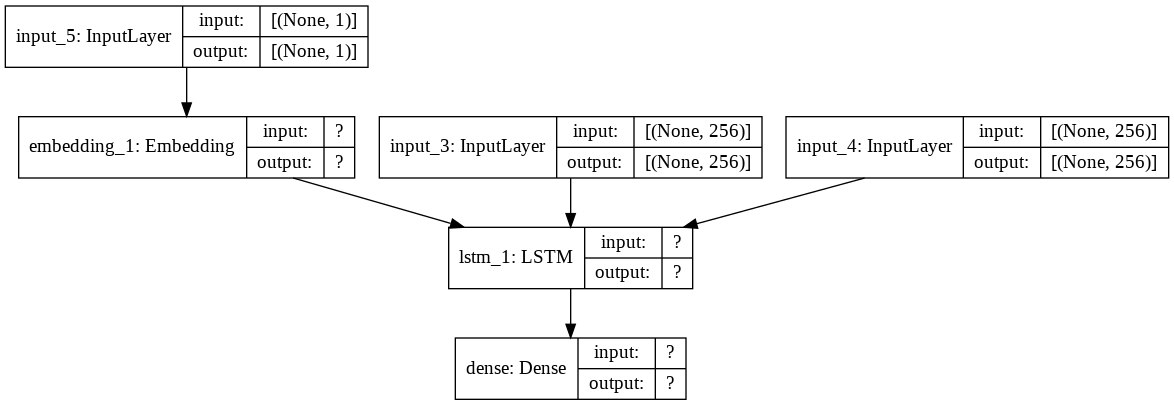

In [34]:
from tensorflow.keras.utils import plot_model
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

In the image above lstm_2 is the modified decoder LSTM. You can see that it accepts the sentence with with one word as shown in input_5, and the hidden and cell states from the previous output (input_3 and input_4). You can see that the shape of the of the input sentence is now (none,1) since there will be only one word in the decoder input. On the contrary, during training the shape of the input sentence was (None,6) since the input contained a complete sentence with a maximum length of 5.

### Making predictions

In [35]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [36]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq= np.zeros((1,1))
    target_seq[0,0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence1 = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word1 = ''

        if idx > 0:
            word1 = idx2word_target[idx]
            output_sentence1.append(word1)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence1)

In the script above, we pass the input sequence to the `encoder_model`, which predicts the hidden state and the cell state, which are stored in `states_value` variable.

Next, we define a variable `target_seq`, which is a `1x1` matrix of all zeros. The `target_seq` variable contains the first word to the decoder mode, which is `<sos>`.

After that, the `eos` variable is initialized, which stores the integer value for the `<eos>` token. In the next line, the `output_sentence` list is defined, which will contain the predicted translation.

Next, we execute a for loop till the length of longest sentence in output. Here the `decoder_model` predicts the output and hidden and cell state, using the h and c state encoder, and input token `<sos>`. The index of predicted word is stored in `idx` variable. If the value of the predicted index is equal to the `<eos>` token, the loop terminates. Else if the predicted index is greater than zero, the corresponding word is retreived from the `idx2word` dictionary and is stored in `word` variable, which is then appeded to the `output_sentence` list.

The `state_value` variable is updated with the new hidden and cell state of the decoder and the index of the prediced word is stored in the `target_seq` variable. In the next loop cycle, the updated hidden and cellstates, along with the index of the previously predicted word, are used to make new predictions. The loops continues until the maximum output sequence lenght is achieved or the `<eos>` token is encountered

### Testing model

In [37]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: Use this.
Response: <sos> elle elle elle elle elle elle elle elle elle elle
